In [17]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima 
import json
import warnings
from statsmodels.tsa.stattools import adfuller
import numpy as np
warnings.filterwarnings("ignore")

In [18]:
######
# Helpler functions intialized
#

def adfuller_test(sales):
    result=adfuller(sales)
    print(result)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")



In [19]:
# read in the dataframe and convert it into a series
stock_data = pd.read_csv("IBM_Stock_Data.csv").set_index("Date")
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.rename(columns={"IBM":"Close"})
stock_series = stock_data['Close']

In [20]:
stock_series.describe().round(2)

count    15842.00
mean        63.84
std         57.81
min          3.90
25%         15.68
50%         29.56
75%        114.64
max        238.04
Name: Close, dtype: float64

In [21]:
######
# Cut-off some of the data for faster computation times
BC_3_End = "2000-09-30"

stock_series_reduced = stock_series.loc[BC_3_End:]

In [22]:
# describe
stock_series_reduced.describe().round(2)

count    6084.00
mean      127.94
std        36.27
min        52.65
25%        95.78
50%       127.40
75%       152.54
max       238.04
Name: Close, dtype: float64

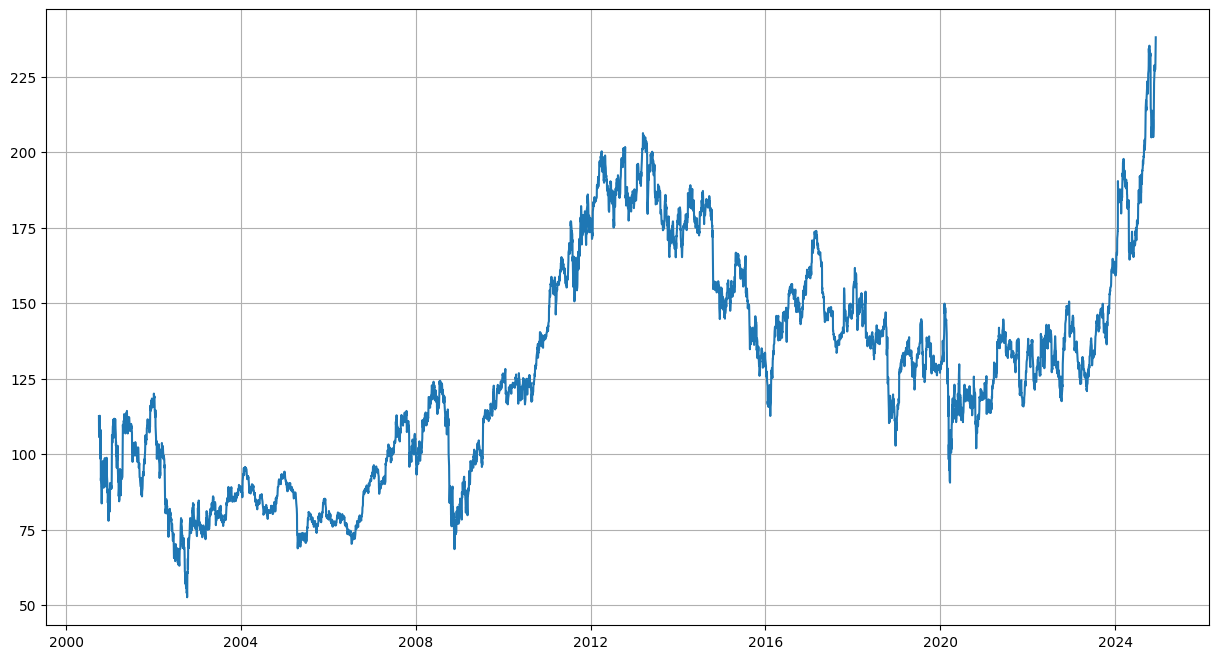

In [23]:
plt.figure(figsize=(15, 8))
plt.plot(stock_series_reduced)
plt.grid(True)
plt.show()

1. Check for Staionarity

In [24]:
adfuller_test(stock_series_reduced)

(np.float64(-0.642779146757885), np.float64(0.8610198090935663), 25, 6058, {'1%': np.float64(-3.431429906412331), '5%': np.float64(-2.8620172202049456), '10%': np.float64(-2.5670240217372706)}, np.float64(24757.2053627653))
ADF Test Statistic : -0.642779146757885
p-value : 0.8610198090935663
#Lags Used : 25
Number of Observations : 6058
weak evidence against null hypothesis,indicating it is non-stationary 


2. Due to the Data being Non-stationary let's diffrence the data 

In [25]:
stock_series_diff= stock_series_reduced.diff().dropna()

In [26]:
stock_series_diff.describe()

count    6083.000000
mean        0.020616
std         1.897277
min       -16.790154
25%        -0.855637
50%         0.047798
75%         0.936905
max        16.500000
Name: Close, dtype: float64

In [27]:
adfuller_test(stock_series_diff)

(np.float64(-17.34411445670989), np.float64(5.3184674129514426e-30), 24, 6058, {'1%': np.float64(-3.431429906412331), '5%': np.float64(-2.8620172202049456), '10%': np.float64(-2.5670240217372706)}, np.float64(24752.316814394628))
ADF Test Statistic : -17.34411445670989
p-value : 5.3184674129514426e-30
#Lags Used : 24
Number of Observations : 6058
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


3. Plot the differenciated data, below it looks like there is a mean close to zero and a stable variance 

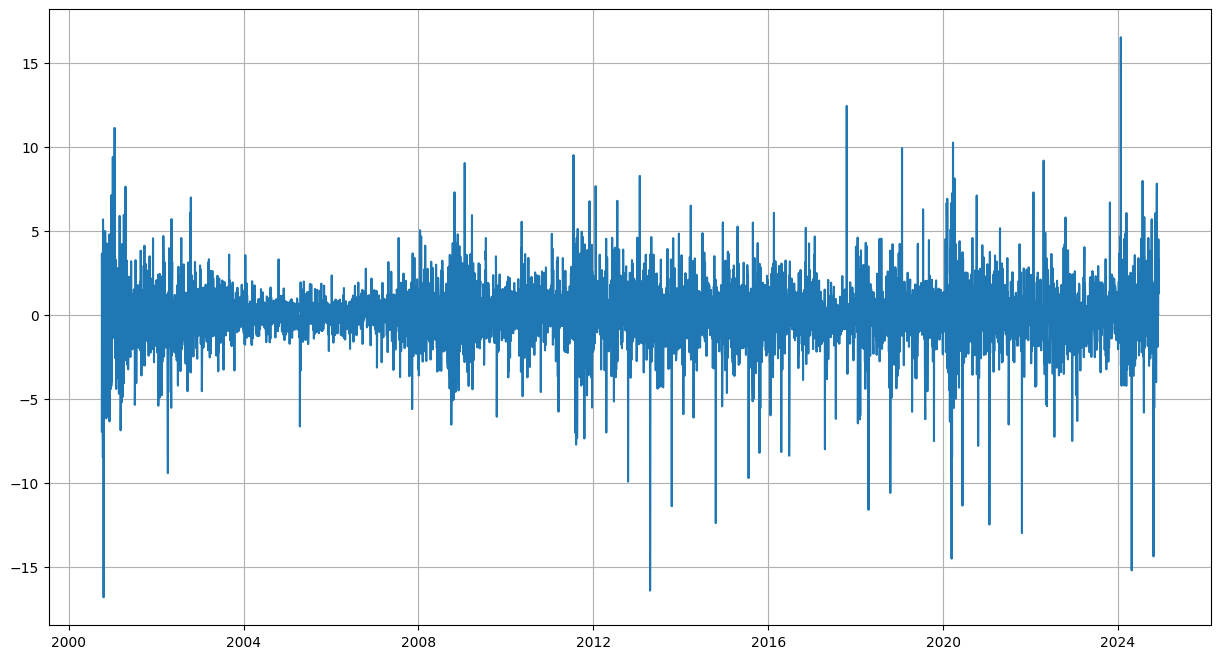

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(stock_series_diff)
plt.grid(True)
plt.show()

# 3. Now the data is stationary, let's look for seasonlity

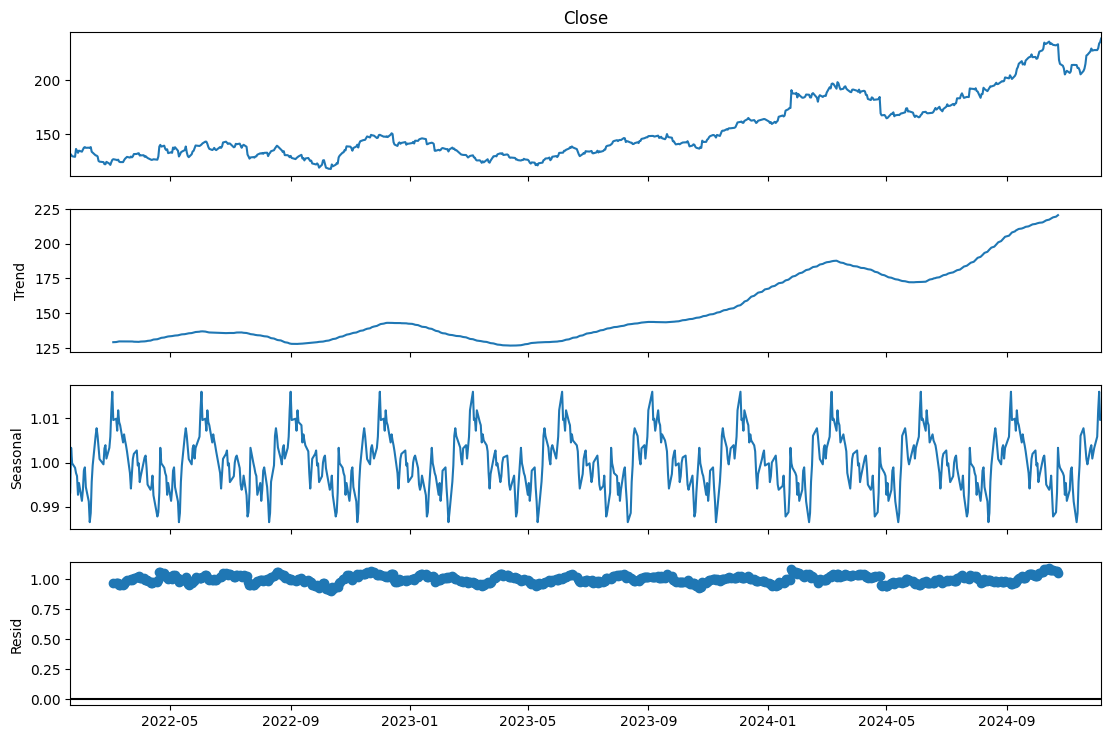

In [29]:
decomposition = seasonal_decompose(stock_series_reduced.tail(726), model='multiplicative', period=63)  # Assuming about 252 trading days in a year
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

Above Shows that there is some seasonsality when it comes to 63 or quaterly earnings

# 4. Now let's plot the auto and partial auto correlation functions

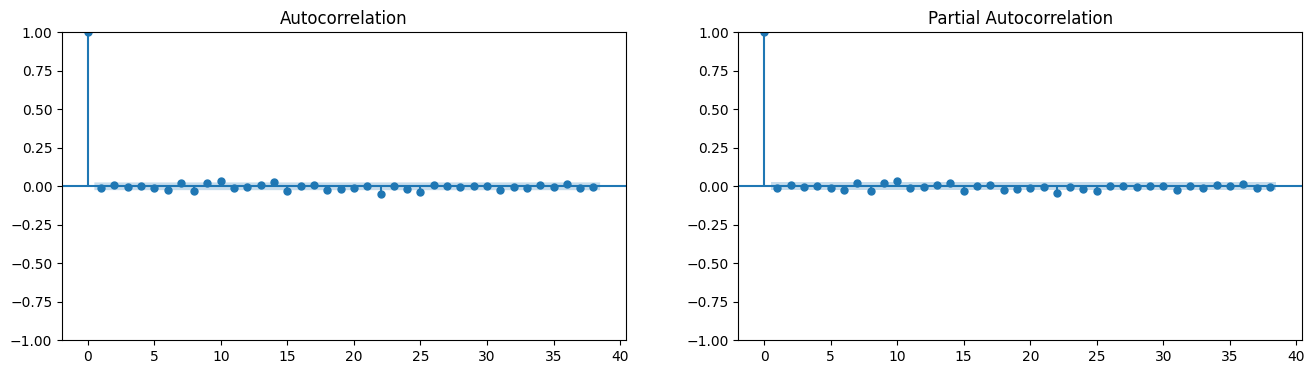

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(stock_series_diff, ax=axes[0])
plot_pacf(stock_series_diff, ax=axes[1])
plt.show()

# Interpretation

- This suggests that there are no strong Auto-Regressive or Moving Average Orders therefore this implies that the model should p=0 , q=0 and d=1 because there was one differencing required

(np.float64(-8.387926642671554), np.float64(2.4100697083506667e-13), 14, 6006, {'1%': np.float64(-3.431439260252058), '5%': np.float64(-2.862021352992292), '10%': np.float64(-2.5670262217280997)}, np.float64(28505.778231270255))
ADF Test Statistic : -8.387926642671554
p-value : 2.4100697083506667e-13
#Lags Used : 14
Number of Observations : 6006
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


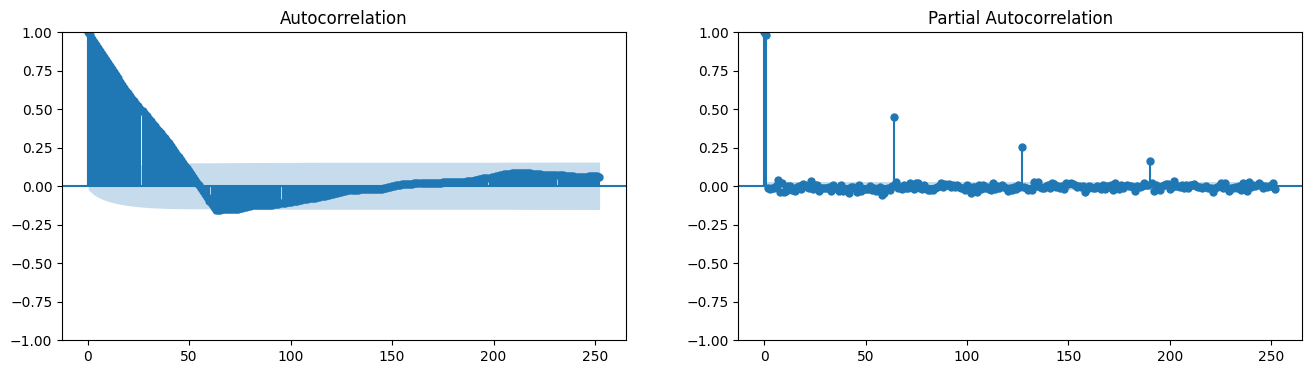

In [31]:
m = 63
seasonal_diff = stock_series_reduced.diff(m).dropna()

adfuller_test(seasonal_diff)


fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(seasonal_diff, lags=4*m, ax=axes[0])
plot_pacf(seasonal_diff, lags=4*m, ax=axes[1])
plt.show()

#### Interpretation

- Seasonal Differencing (D): This suggest that seasonal compenet of the arima model should be D=1 as we differenced the data at the seasonal frequnecy m=63. 
- Seasonal MA (Q): If the seasonal moving average term was needed you typically see a large isolated spike at the 63 lag, but due it not being isolated to implies that Q=0
- Seasonal AR (P): The seasonal AR effect is fully removed after diffrencing, in addition we can see that the seasonal lag is isolated and significant, therefore P=1


In [32]:
#####
# intialize params
###


p,d,q = 0,1,0
P, D, Q, M = 1, 1, 0, 63



model = SARIMAX(stock_series_reduced, order=(p,d,q), seasonal_order=(P, D, Q, M))
results = model.fit()
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22783D+00    |proj g|=  1.19008D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   1.647D-06   2.228D+00
  F =   2.2275248989426113     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 6084
Model:      

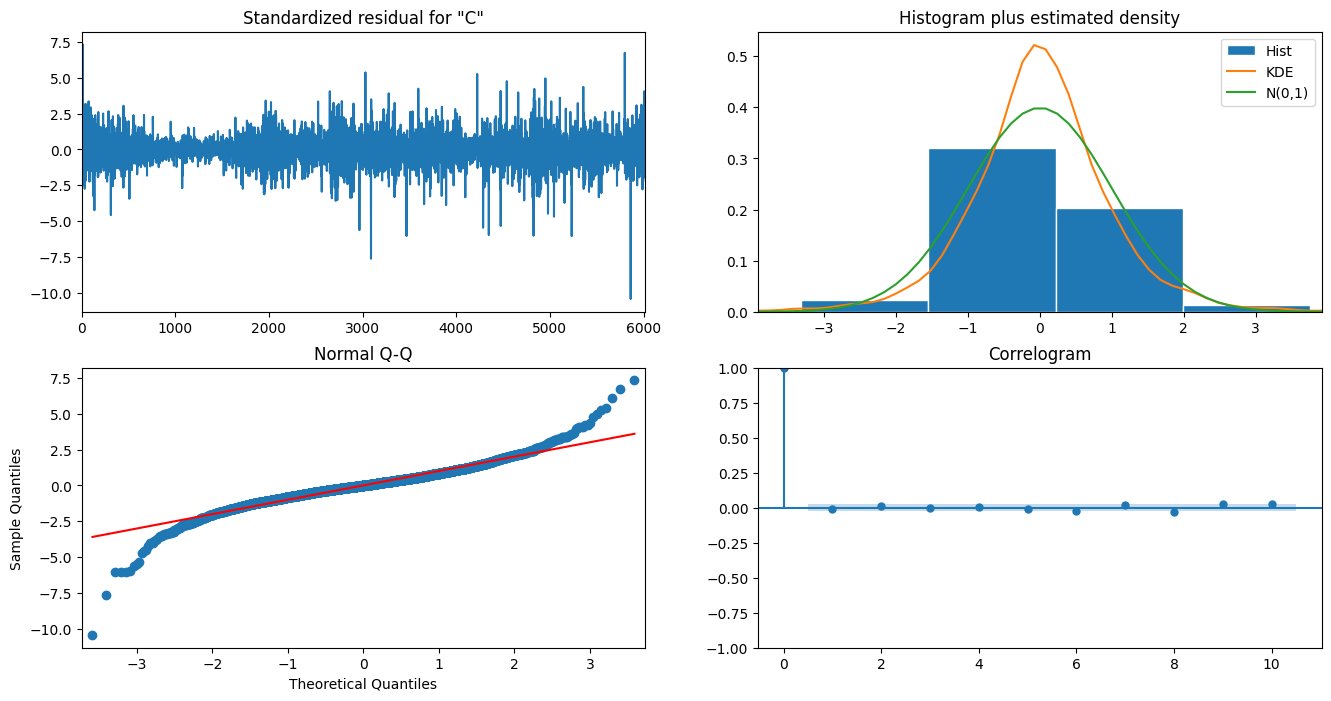

In [33]:
r = results.plot_diagnostics(figsize=(16,8))

In [34]:
# Forecast the next 5 years (assuming ~252 trading days per year)
steps = 252 * 5  # 1260 steps
last_date = stock_series_reduced.index[-1]

forecast = results.get_forecast(steps=steps)

# Extract predicted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
new_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=1260, freq='B')
forecast_mean.index = new_index
forecast_ci.index = new_index

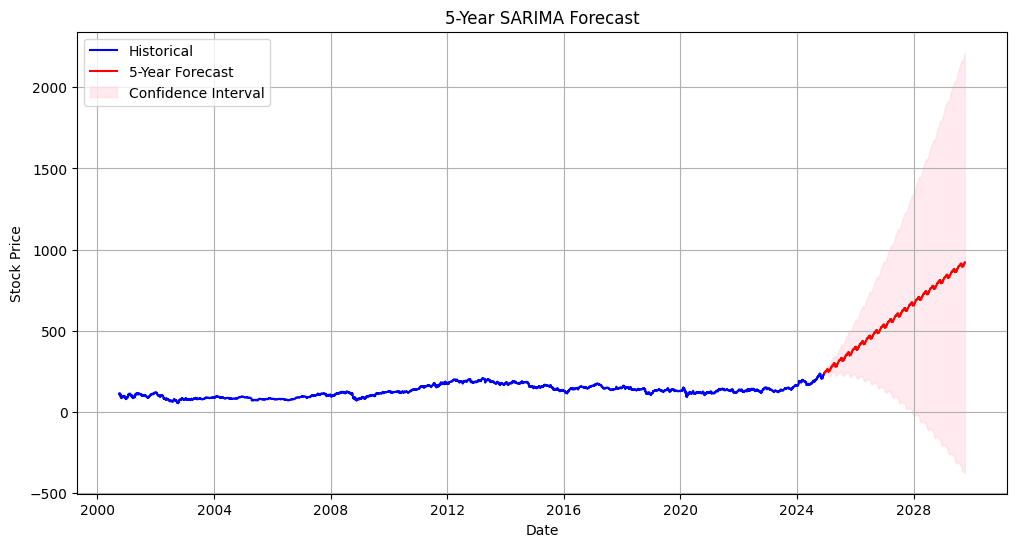

In [35]:

# Plot the historical and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(stock_series_reduced, label='Historical', color='blue')
plt.plot(forecast_mean, label='5-Year Forecast', color='red')

# Fill between the confidence intervals
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title('5-Year SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

##### Added the trading scheme from AlgorithmicTrading.ipynb

In [36]:
#####
# moving average function, simply calls on a string then run's either a simple or exponetially weighted moving average
##

def create_MA(stock_data, short_window, long_window, method):

    if method == "SMA":
        stock_data["short_window"] = stock_data["Close"].rolling(short_window).mean()
        stock_data["long_window"] = stock_data["Close"].rolling(long_window).mean()
    if method == "EMA":
        stock_data["short_window"] = stock_data["Close"].ewm(short_window).mean()
        stock_data["long_window"] = stock_data["Close"].ewm(long_window).mean()

    return stock_data.dropna()

#### 
# This function intializes the variables as new columns 
# Then shifts the columns down to obtain two new columns used to detect the status of the short and long windows before the crossing
# A buy signal happens if the short_window is greater than the long window and the pervoius short window was less than the long window and vice versa for sell signials

def detect_crosses(stock_data):

    stock_data = stock_data.copy()

    stock_data['signal'] = 0
    stock_data['Action'] = ""  
    stock_data['Shares_Owned'] = 0
    stock_data['Profit'] = 0.0
    stock_data['Cumulative_Profit'] = 0.0


    stock_data['prev_short_window'] = stock_data['short_window'].shift(1)
    stock_data['prev_long_window'] = stock_data['long_window'].shift(1)

    # buy
    stock_data.loc[(stock_data['short_window'] > stock_data['long_window']) & 
             (stock_data['prev_short_window'] <= stock_data['prev_long_window']), 'signal'] = 1

    # sell
    stock_data.loc[(stock_data['short_window'] < stock_data['long_window']) & 
             (stock_data['prev_short_window'] >= stock_data['prev_long_window']), 'signal'] = -1

    stock_data.drop(['prev_short_window', 'prev_long_window'], axis=1, inplace=True)

    return stock_data

# This function takes in the data
# The iterates over the length of the dataframe using the index  as well as iloc to obtain the signals
# depeding on the signal if it's a buy ten shares are bought at the current closing price
# using the .at[] we then can assign this to teh actions column
# if it's a sell,  we make sure that we subtract it form the last sell price to obtain the total prfit
# re use the .at[] to assign the actions as well as the proit to the actions column
# we also calculate total profit that can put into the cululate profit column, and reset the shares owned
# if there is no signal then we hold our current shares
####

def execute_trades(data):

    data = data.copy()
    trades = []
    shares_owned = 0
    total_profit = 0
    purchase_price = 0


    # Add columns to track trading activity
    data.loc[:, 'Action'] = ""  
    data.loc[:, 'Shares_Owned'] = 0
    data.loc[:, 'Profit'] = 0.0
    data.loc[:, 'Cumulative_Profit'] = 0.0

    for i in range(len(data)):
        if data['signal'].iloc[i] == 1:  
            shares_owned += 10
            purchase_price = data['Close'].iloc[i]
            data.at[data.index[i], 'Action'] = "Buy"
            trades.append({"Type": "Buy", "Price": purchase_price, "Shares": 10, "Date": data.index[i]})

        elif data['signal'].iloc[i] == -1:  
            if purchase_price == 0:  # Safety check to avoid invalid profit calculations
                continue
            
            sell_price = data['Close'].iloc[i]
            profit = (sell_price - purchase_price) * shares_owned
            total_profit += profit
            data.at[data.index[i], 'Action'] = "Sell"
            data.at[data.index[i], 'Profit'] = profit
            trades.append({"Type": "Sell", "Price": sell_price, "Shares": shares_owned, "Date": data.index[i], "Profit": profit})
            shares_owned = 0  # Reset shares after sale
            purchase_price = 0

        else:
            data.at[data.index[i], 'Action'] = "Hold"

        
        data.at[data.index[i], 'Shares_Owned'] = shares_owned
        data.at[data.index[i], 'Cumulative_Profit'] = total_profit

    data['Portfolio_Size'] = data['Shares_Owned'] * data['Close']

    return data

#####
# Wrapper function that organizes all the trading

def trading_scheme(data, short_window, long_window, method):
    data = data.copy()

    # Step 1: Calculate trends
    data = create_MA(data, short_window, long_window, method)

    # Step 2: Generate signals
    data = detect_crosses(data)

    # Step 3: Execute trades and maintain detailed log
    data = execute_trades(data)


    return data

In [37]:
df = forecast_mean.to_frame()
df = forecast_mean.reset_index()
df.columns = ["Date", "Close"]
df = df.set_index("Date")
df

,Close
Date,
2024-12-09,239.094858
2024-12-10,240.750163
2024-12-11,241.414036
2024-12-12,243.009845
2024-12-13,244.199483
...,...
2029-10-01,913.586085
2029-10-02,915.612242
2029-10-03,918.052168


In [38]:
results_trading = trading_scheme(df, 180, 320, method="EMA")

In [39]:
#####
## Helper function used to format the x-axis to prevent over-crowding
def format_xticks(axes):
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.YearLocator(5)) 
        ax.xaxis.set_minor_locator(mdates.YearLocator(1)) 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

#####
# Helper function that is used to plot the alogrithmic trading process,
#
# The first plot has 4 different lines/scatter points
# first two are simple plots of the short and long term moving averages
# The last two maps out buy and sell signals and adds '^' or 'v' markers to make it look better
# 
# The second subplot simply traces the profit

def plot_trading_results(data, title):

    fig, axes = plt.subplots(2, 1, figsize=(15, 25), sharex=True)
    fig.suptitle(title, fontsize=16)

    axes[0].plot(data.index, data['short_window'], label="Short-Term MA", color='blue')
    axes[0].plot(data.index, data['long_window'], label="Long-Term MA", color='orange')
    axes[0].scatter(data[data['Action'] == 'Buy'].index, data[data['Action'] == 'Buy']['short_window'], 
                    label="Buy Signal", color='green', marker='^', s=100)
    axes[0].scatter(data[data['Action'] == 'Sell'].index, data[data['Action'] == 'Sell']['short_window'], 
                    label="Sell Signal", color='red', marker='v', s=100)
    axes[0].set_title("Short-Term and Long-Term Moving Averages with Buy/Sell Signals")
    axes[0].set_ylabel("Price (USD)")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(data.index, data['Cumulative_Profit'], label="Cumulative Profit", color='purple')
    axes[1].set_title("Cumulative Profit Over Time")
    axes[1].set_ylabel(f"Profit (USD)")
    axes[1].set_xlabel("Date")
    axes[1].legend()
    axes[1].grid(True)

    format_xticks(axes)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



In [40]:
results_trading

,Close,short_window,long_window,signal,Action,Shares_Owned,Profit,Cumulative_Profit,Portfolio_Size
Date,,,,,,,,,
2024-12-09,239.094858,239.094858,239.094858,0,Hold,0,0.0,0.0,0.000000
2024-12-10,240.750163,239.924803,239.923802,1,Buy,10,0.0,0.0,2407.501626
2024-12-11,241.414036,240.423967,240.422097,0,Hold,10,0.0,0.0,2414.140362
2024-12-12,243.009845,241.075819,241.072065,0,Hold,10,0.0,0.0,2430.098453
2024-12-13,244.199483,241.707493,241.701458,0,Hold,10,0.0,0.0,2441.994833
...,...,...,...,...,...,...,...,...,...
2029-10-01,913.586085,820.775808,758.239618,0,Hold,10,0.0,0.0,9135.860854
2029-10-02,915.612242,821.300262,758.739779,0,Hold,10,0.0,0.0,9156.122417
2029-10-03,918.052168,821.835305,759.246073,0,Hold,10,0.0,0.0,9180.521677


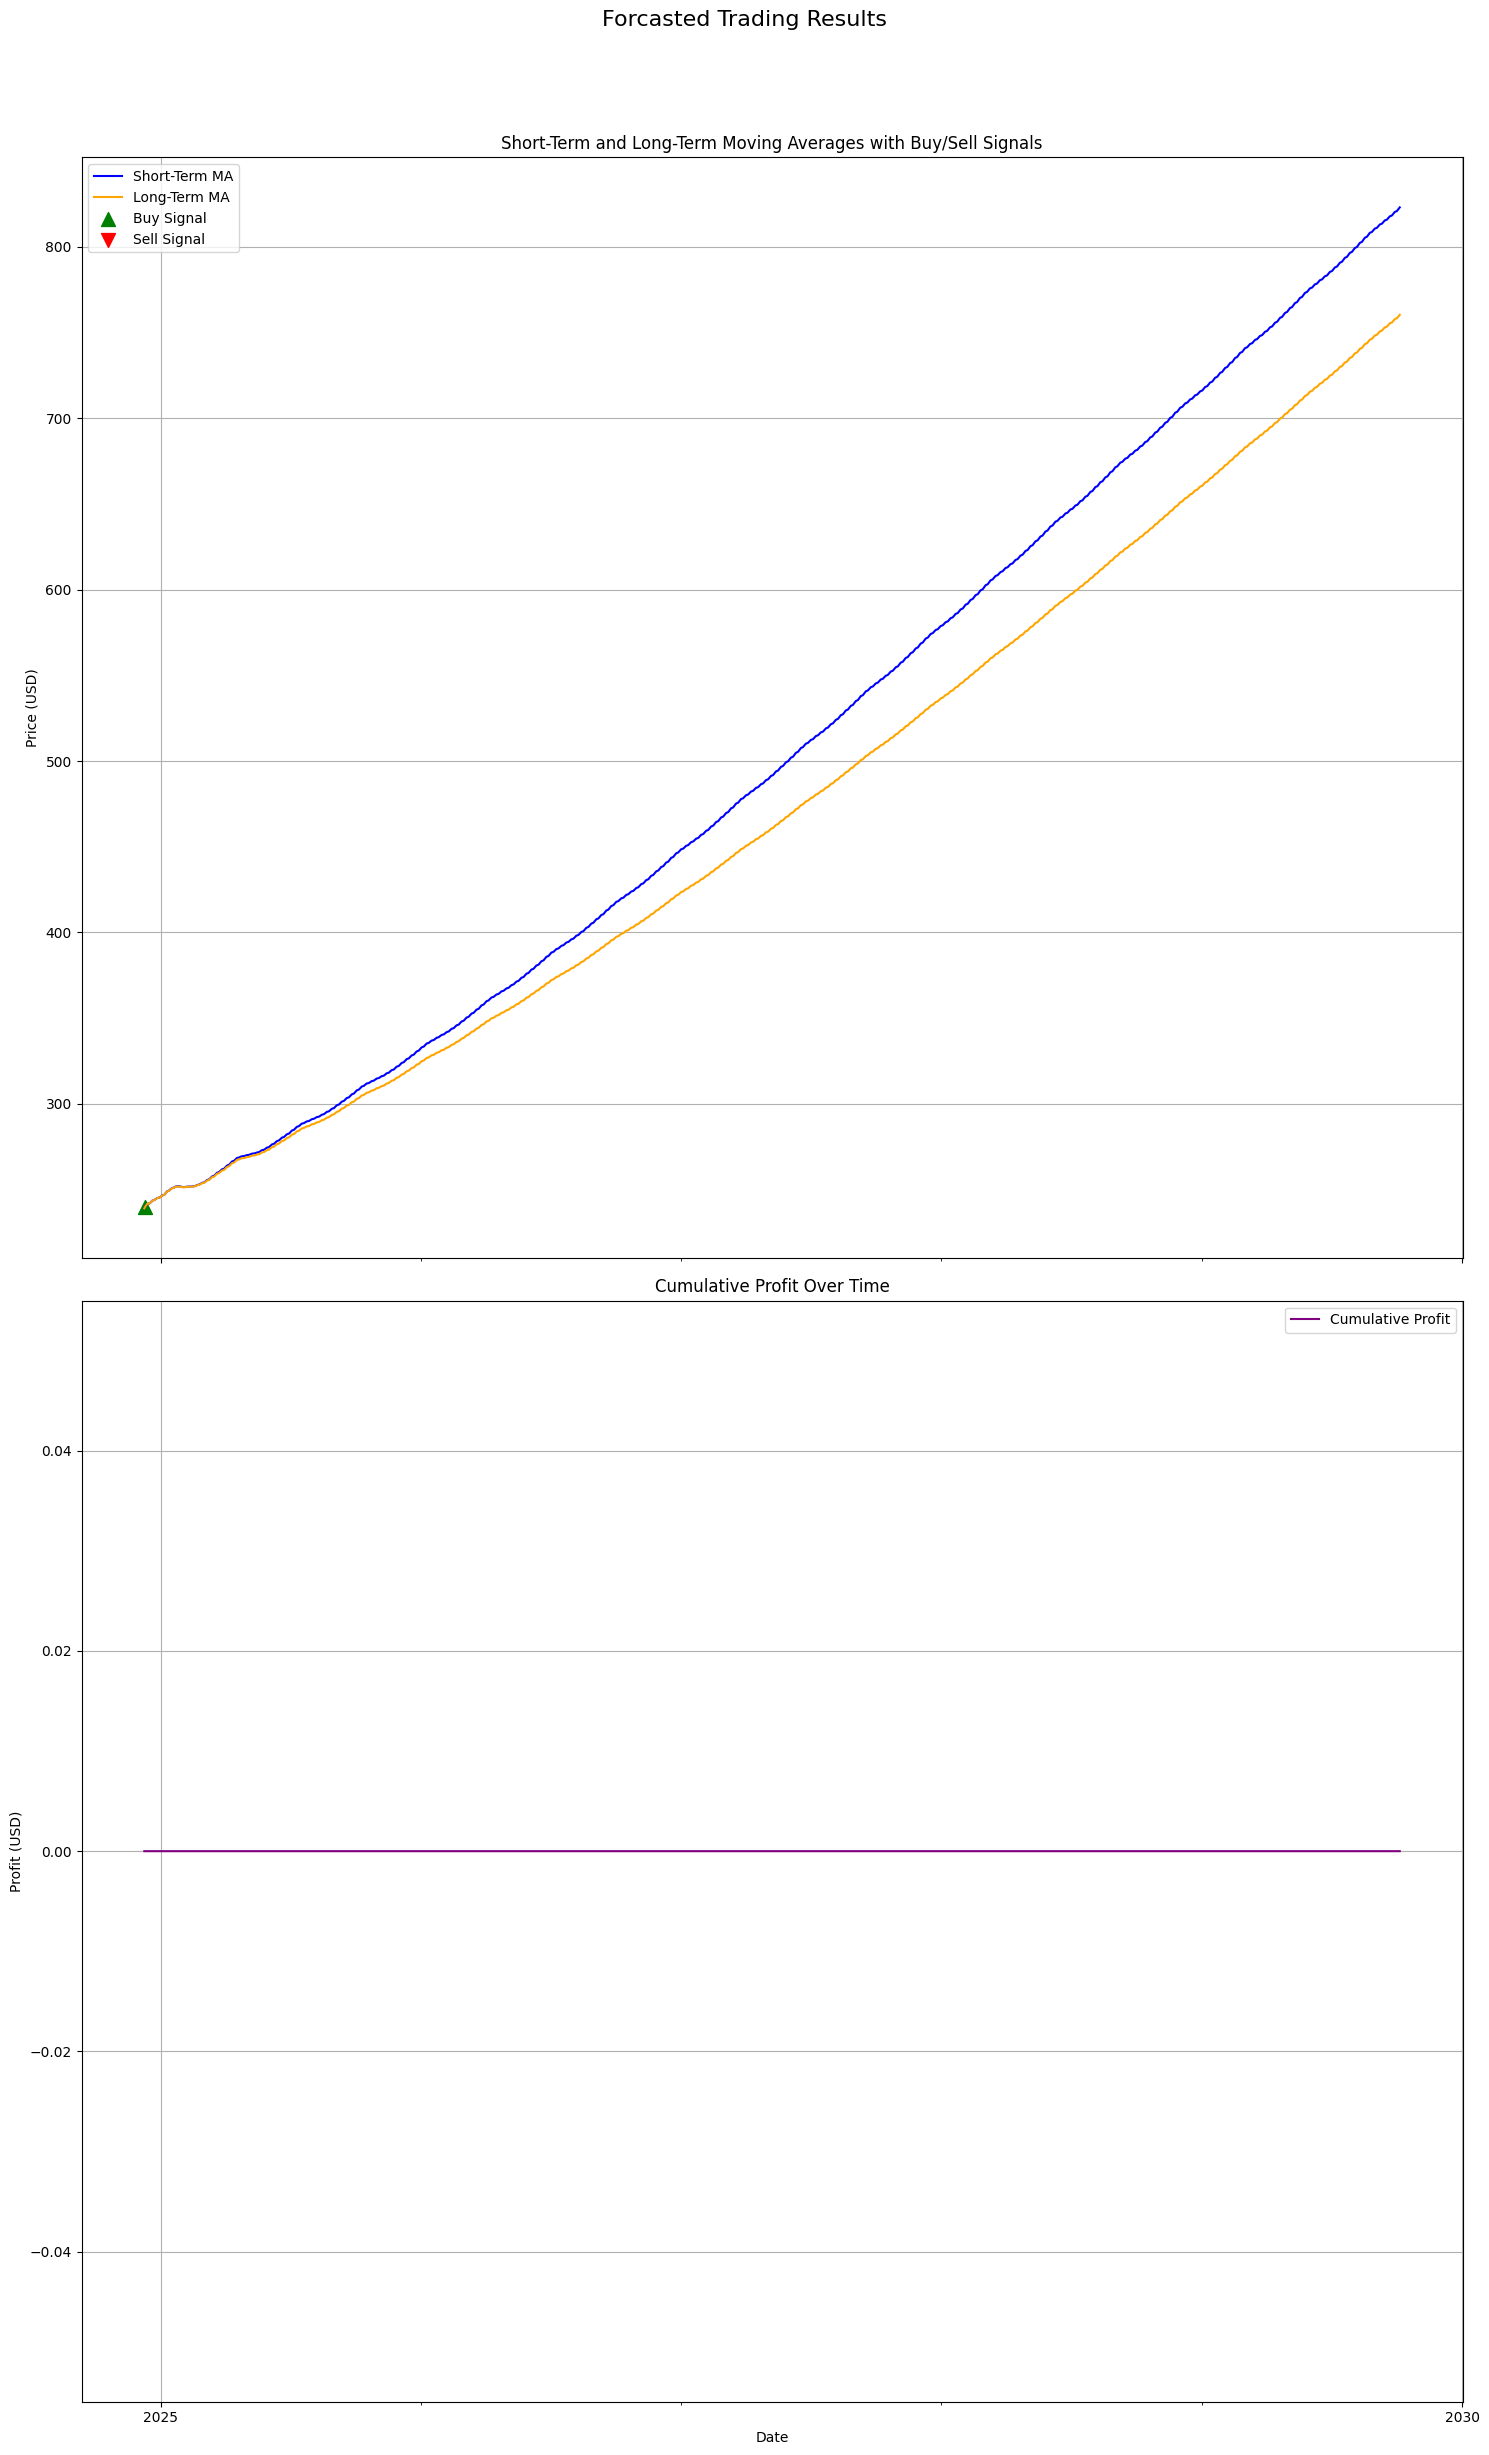

In [41]:
plot_trading_results(results_trading, "Forcasted Trading Results")